<a href="https://colab.research.google.com/github/goguaD/ass4/blob/main/meotxe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install torch torchvision torchaudio
!pip install wandb
!pip install kaggle

In [41]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ditogogua","key":"62967aa3b26215f60cc8e8dd4363b3f2"}'}

In [42]:
!pip install -q kaggle

In [43]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [44]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [45]:
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d data/

replace data/example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/fer2013.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
replace data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y


In [46]:
!ls data

example_submission.csv	fer2013.tar.gz	icml_face_data.csv  test.csv  train.csv


In [47]:
!pip install -q wandb

In [48]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import wandb


In [50]:
train_df_t = pd.read_csv('/content/data/icml_face_data.csv')

In [51]:
test_df = pd.read_csv('/content/data/test.csv')

In [52]:
test_df.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [53]:
train_df_t[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [54]:
train_df_t.shape

(35887, 3)

In [55]:
train = train_df_t[train_df_t[' Usage'] == 'Training']
val = train_df_t[train_df_t[' Usage'] == 'PrivateTest']
test = train_df_t[train_df_t[' Usage'] == 'PublicTest']

In [56]:
print("Training samples:", len(train))
print("Validation samples:", len(val))
print("Test samples:", len(test))

Training samples: 28709
Validation samples: 3589
Test samples: 3589


In [57]:
print("\nClass distribution in training set:")
print(train['emotion'].value_counts())


Class distribution in training set:
emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64


In [58]:
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


Sample training images:


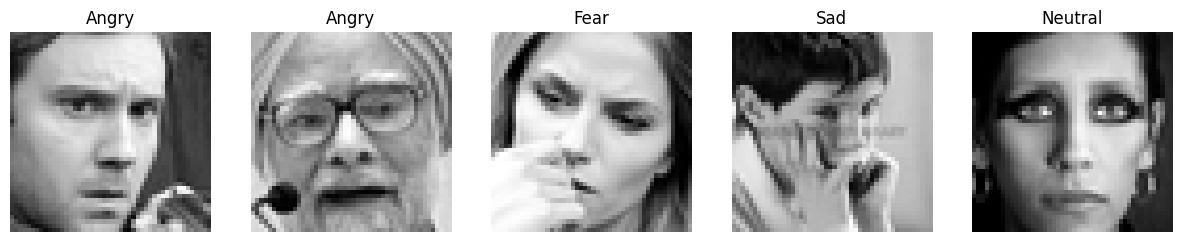

In [59]:
import matplotlib.pyplot as plt

def plot_sample_images(df, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        sample = df.iloc[i]
        pixels = np.array(sample[' pixels'].split(), dtype='uint8')
        img = pixels.reshape(48, 48)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(emotion_labels[sample['emotion']])
        axes[i].axis('off')
    plt.show()

print("\nSample training images:")
plot_sample_images(train)

In [60]:
class FERDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = self.df.iloc[idx][' pixels']
        pixels = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
        image = Image.fromarray(pixels)

        if self.transform:
            image = self.transform(image)

        label = self.df.iloc[idx]['emotion']
        return image, label

In [61]:
from PIL import Image
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [62]:
train_dataset = FERDataset(train, transform=transform_train)
val_dataset = FERDataset(val, transform=transform_val)
test_dataset = FERDataset(test, transform=transform_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [63]:
class AdvancedFaceCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(AdvancedFaceCNN, self).__init__()

        # Enhanced feature extraction
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d(1)
        )

        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [76]:
wandb.init(project='facial-expression-recognition', entity=None)  # Replace with your W&B entity

In [65]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(data_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdvancedFaceCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Smoothed loss
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # Better optimizer
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)  # Stronger scheduler

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    best_val_acc = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update LR per batch (OneCycleLR)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Log to W&B
        if wandb.run is not None:
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'lr': scheduler.get_last_lr()[0]  # Current learning rate
            })

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, 'best_model.pth')
            print('Best model saved!')

    model.load_state_dict(best_model_weights)
    return model

In [73]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

Epoch [1/30], Train Loss: 1.1898, Train Acc: 63.90%, Val Loss: 1.1238, Val Acc: 66.73%, LR: 0.005670
Best model saved!
Epoch [2/30], Train Loss: 1.1723, Train Acc: 64.94%, Val Loss: 1.1276, Val Acc: 66.87%, LR: 0.005223
Best model saved!
Epoch [3/30], Train Loss: 1.1639, Train Acc: 65.33%, Val Loss: 1.1039, Val Acc: 67.15%, LR: 0.004775
Best model saved!
Epoch [4/30], Train Loss: 1.1584, Train Acc: 65.83%, Val Loss: 1.1099, Val Acc: 67.18%, LR: 0.004328
Best model saved!
Epoch [5/30], Train Loss: 1.1446, Train Acc: 66.48%, Val Loss: 1.0949, Val Acc: 68.38%, LR: 0.003886
Best model saved!
Epoch [6/30], Train Loss: 1.1351, Train Acc: 66.87%, Val Loss: 1.0969, Val Acc: 69.02%, LR: 0.003454
Best model saved!
Epoch [7/30], Train Loss: 1.1214, Train Acc: 67.71%, Val Loss: 1.0816, Val Acc: 68.77%, LR: 0.003034
Epoch [8/30], Train Loss: 1.1108, Train Acc: 68.22%, Val Loss: 1.0701, Val Acc: 69.66%, LR: 0.002630
Best model saved!
Epoch [9/30], Train Loss: 1.1041, Train Acc: 68.38%, Val Loss: 1.0

ValueError: Tried to step 22451 times. The specified number of total steps is 22450

In [74]:
print("\nEvaluating on test set...")
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


Evaluating on test set...
Test Loss: 1.0938, Test Accuracy: 69.35%


In [77]:
wandb.log({'test_loss': test_loss, 'test_acc': test_acc})


Test set confusion matrix:


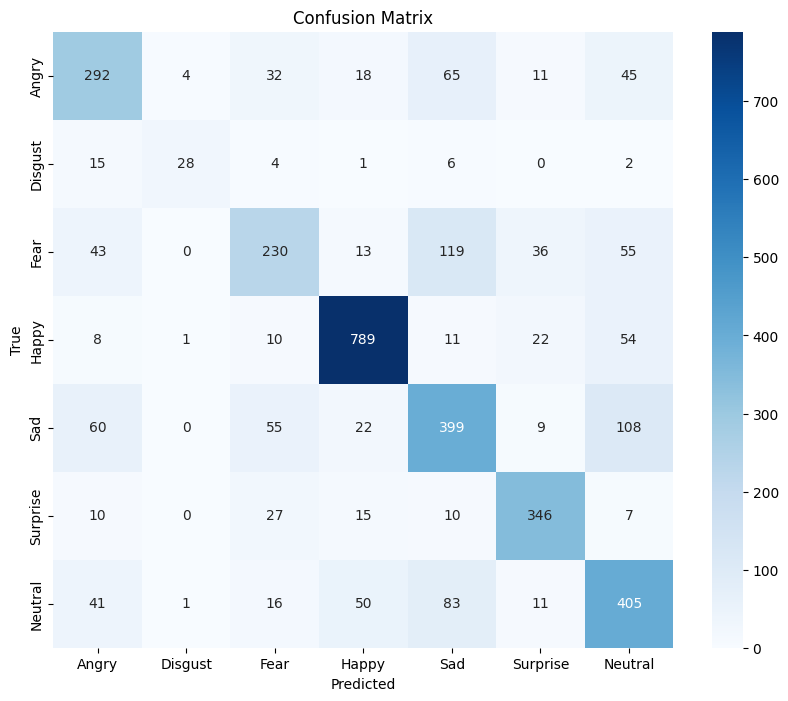


Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.63      0.62       467
     Disgust       0.82      0.50      0.62        56
        Fear       0.61      0.46      0.53       496
       Happy       0.87      0.88      0.88       895
         Sad       0.58      0.61      0.59       653
    Surprise       0.80      0.83      0.81       415
     Neutral       0.60      0.67      0.63       607

    accuracy                           0.69      3589
   macro avg       0.70      0.65      0.67      3589
weighted avg       0.69      0.69      0.69      3589



In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Modify the plot_confusion_matrix function to return predictions and labels
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels.values(),
                yticklabels=emotion_labels.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return cm, all_labels, all_preds

print("\nTest set confusion matrix:")
cm, all_labels, all_preds = plot_confusion_matrix(model, test_loader)

# Now we can use all_labels and all_preds for the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels.values()))

In [79]:
torch.save(model.state_dict(), 'final_model.pth')
wandb.save('final_model.pth')

['/content/wandb/run-20250607_195907-i6yecouc/files/final_model.pth']

In [80]:
wandb.finish()

test_acc,▁
test_loss,▁
test_acc,69.35079
test_loss,1.09379
